In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
import torch
import torch.nn as nn

class Dehazer(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Dehazer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

#         self.decoder = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#         )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
class DHaze(Dataset):
    def __init__(self, data_dir, transform=None):
        
        self.data_dir = data_dir
        self.transform = transform[0]
        self.target_transform = transform[1]
        self.x = []
        self.y = []
        
        with open(os.path.join(data_dir, 'train_Hazy.txt'), "r") as f:
            for l in f.readlines():
                path = l.strip()
                assert os.path.isfile(path), path
                self.x.append(path)

        with open(os.path.join(data_dir, 'train_tmap.txt'), "r") as f:
            for l in f.readlines():
                assert os.path.isfile(l.strip()), l.strip()
                self.y.append(l.strip())

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.x[idx]))/255
        target = np.array(Image.open(self.y[idx]))/255

        if self.transform is not None:
            image = self.transform(image.astype("float32"))
        if self.target_transform is not None:
            target = self.target_transform(target.astype("float32"))
        
        return image, target

class DHazeTest(Dataset):
    def __init__(self, data_dir, transform):
        
        self.data_dir = data_dir
        self.transform = transform[0]
        self.target_transform = transform[1]
        self.x = []
        self.y = []

        with open(os.path.join(data_dir, 'test_Hazy.txt'), "r") as f:
            for l in f.readlines():
                assert os.path.isfile(l.strip()), l.strip()
                self.x.append(l.strip())

        with open(os.path.join(data_dir, 'test_tmap.txt'), "r") as f:
            for l in f.readlines():
                assert os.path.isfile(l.strip()), l.strip()
                self.y.append(l.strip())
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.x[idx]))/255
        target = np.array(Image.open(self.y[idx]))/255
        
        if self.transform is not None:
            image = self.transform(image.astype("float32"))
        
        if self.target_transform is not None:
            target = self.target_transform(target.astype("float32"))
        
        return image, target    

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(400),
    transforms.CenterCrop(400),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])          
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(400),
    transforms.CenterCrop(400),
])

train_dataset = DHaze("/content/drive/MyDrive/CSE273/dhaze/NYU_split", transform=[transform, target_transform])
test_dataset = DHazeTest("/content/drive/MyDrive/CSE273/dhaze/NYU_split", transform=[transform, target_transform])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32,  shuffle=False)

print(f"Number of batches per epoch in train set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

Number of batches per epoch in train set: 37
Number of batches in test set: 10


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
model = Dehazer(in_channels=3, out_channels=1)
num_params_m = sum(torch.numel(p) for p in model.parameters())
print(f"Number of parameters in the model: {num_params_m}")

criterion = nn.MSELoss()


learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Number of parameters in the model: 3472899


In [26]:
from tqdm import tqdm

In [ ]:
model.to(device)

num_epochs = 50
dataset = 'dhaze'
experiment = f"lr_{learning_rate}_{dataset}_epochs{num_epochs}_test_run"

model_dir = f"/content/drive/MyDrive/CSE273/{experiment}"
!mkdir $model_dir

log_dir = f"/content/drive/MyDrive/CSE273/logs/{experiment}"
writer = SummaryWriter(log_dir)


num_batches = len(train_loader)
for epoch in range(num_epochs):
    
        running_loss = 0.0
        for idx, (images, targets) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
                
            if idx%10 == 0  or num_batches-1 == idx:
                writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + idx)

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

        checkpoint = {
            'epoch' : epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }

        torch.save(checkpoint, f'{model_dir}/checkpoint_epoch_{epoch+1}.pth')

writer.close()

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
37it [00:22,  1.62it/s]


Epoch [1/50], Loss: 0.035448


37it [00:22,  1.62it/s]


Epoch [2/50], Loss: 0.021787


8it [00:05,  1.58it/s]

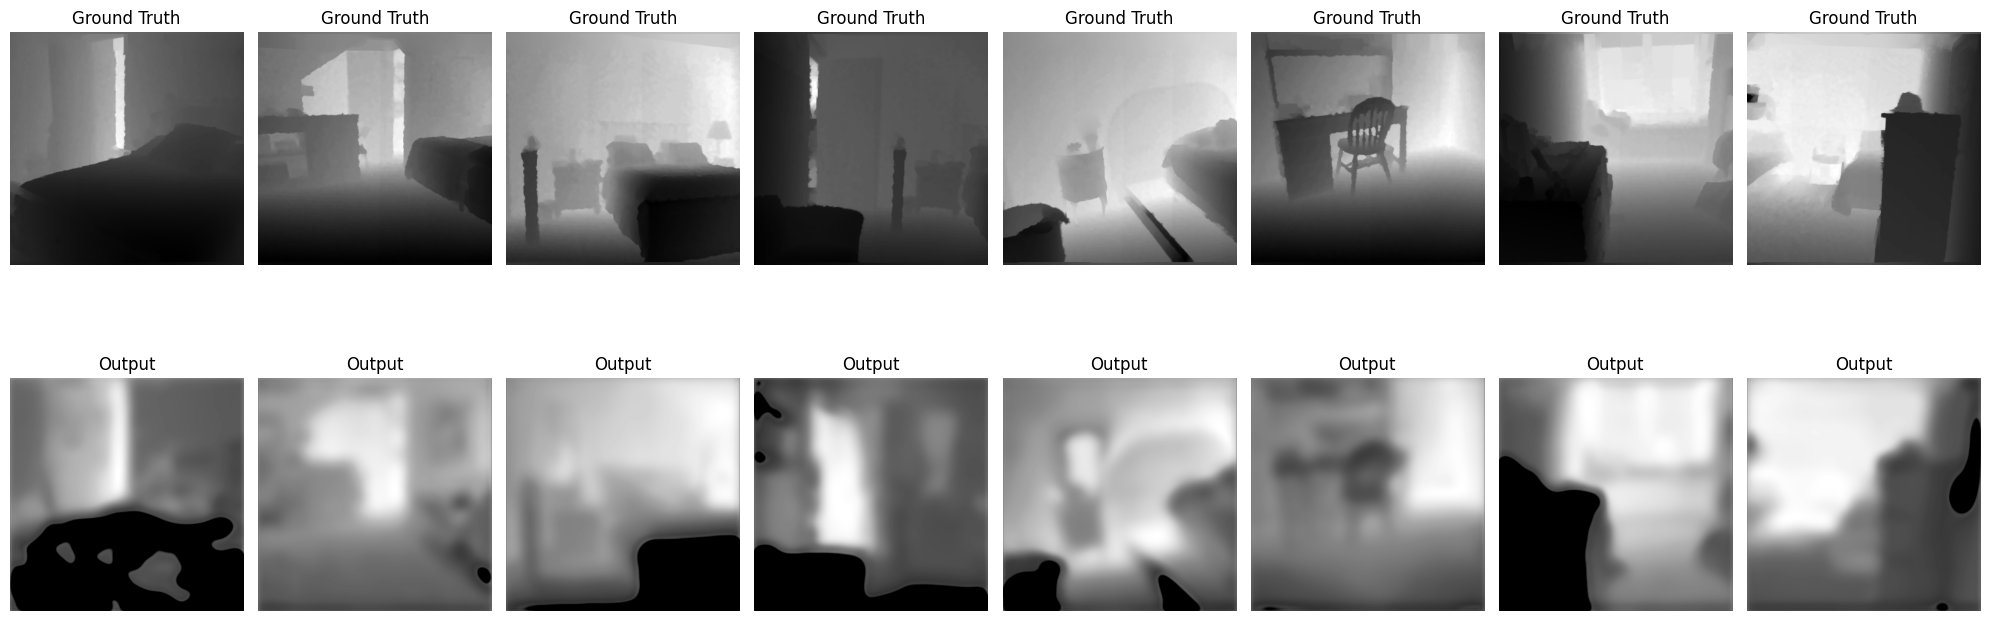

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

batch_size = 32
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Convert the outputs and targets to numpy arrays
        outputs_np = outputs.cpu().numpy()
        targets_np = targets.numpy()
 
        fig, axs = plt.subplots(2, 8, figsize=(20, 8))
        
        for i in range(batch_size):
            axs[0, i].imshow(targets_np[i].transpose(1, 2, 0), cmap='gray')
            axs[0, i].set_title("Ground Truth")
            axs[0, i].axis("off")

            # Plot predicted image in the second row
            axs[1, i].imshow(outputs_np[i].transpose(1, 2, 0), cmap='gray')
            axs[1, i].set_title("Output")
            axs[1, i].axis("off")
            
            if i == 7: break

        plt.tight_layout()
        plt.show()
        break
        
        
